

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=15,
    # randomly shift images horizontally
    width_shift_range=0.05,
    # randomly shift images vertically
    height_shift_range=0.05,
    # randomly flip images
    horizontal_flip=False,
    # randomly flip images
    vertical_flip=False
)    


output_path = os.path.abspath('./output')
data_name = 'mnist'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(60000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.4, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.2, 'epochs':120}, 
        'custom':{'dropout':0.3, 'epochs':120},
        'vgg':{'dropout':0.4, 'epochs':120},
        'resnet':{'epochs':120}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2021-08-10 08:28:52,753: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json


### 下载数据

开始下载数据。

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

# 增加一个通道
train_images = np.expand_dims(train_images, axis=-1) 
test_images = np.expand_dims(test_images, axis=-1) 


print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)




### 查看数据

下面看一看实际的数据是啥样的。

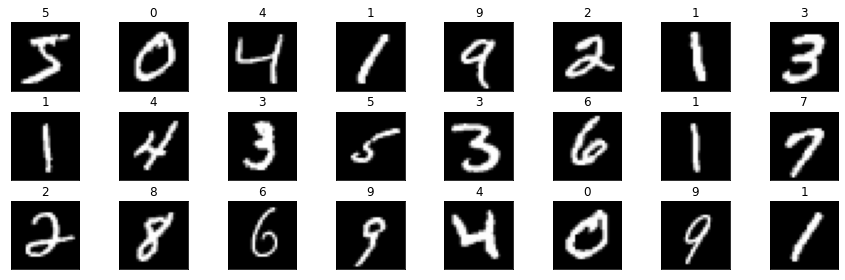

In [5]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

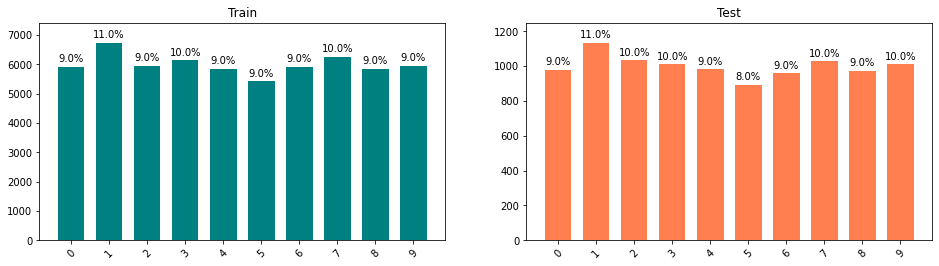

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [7]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [8]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [9]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

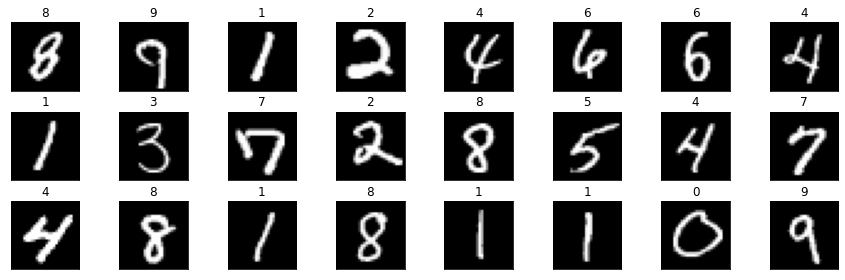

In [10]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [11]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

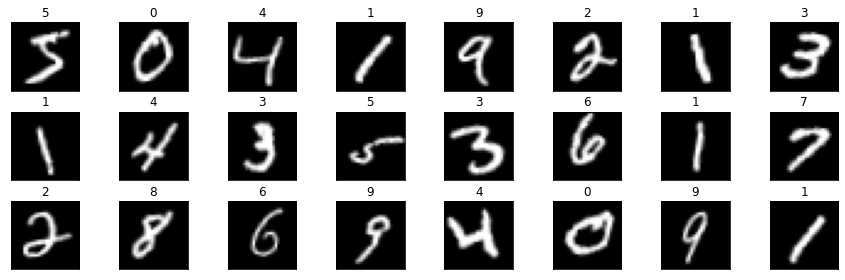

In [12]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

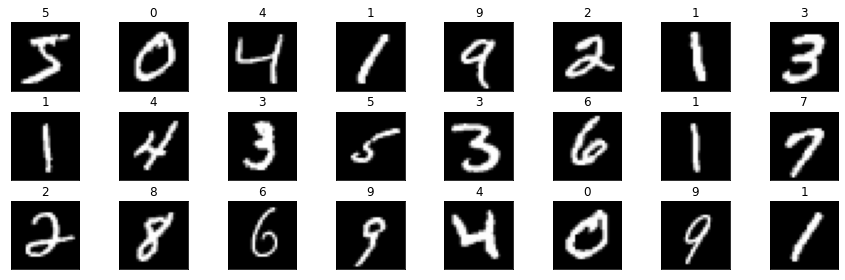

In [13]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [14]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [15]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


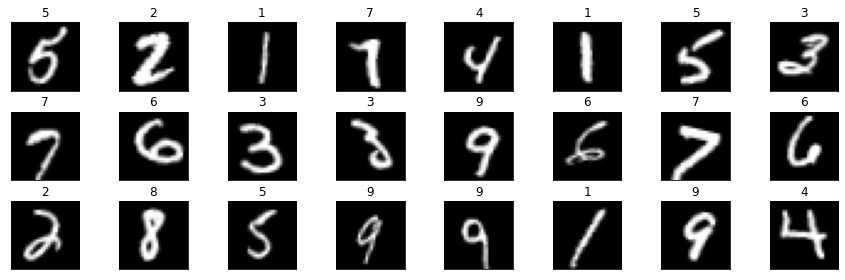

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2021-08-10 08:29:03,298: INFO: model_params.mlp1.dropout=0.4
2021-08-10 08:29:03,299: INFO: model_params.mlp1.layer_count=1
2021-08-10 08:29:03,300: INFO: model_params.mlp1.units=128
2021-08-10 08:29:03,369: INFO: learning_rate=0.001
2021-08-10 08:29:03,370: INFO: model_params.mlp1.clip_value=None
2021-08-10 08:29:03,392: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1
2021-08-10 08:29:03,395: INFO: model_params.mlp1.epochs=120
2021-08-10 08:29:03,395: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1, monitor=val_accuracy)
2021-08-10 08:29:03,396: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:29:03,397: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:29:03,398: INFO: use LearningRateScheduler()
2021-08-10 08:29:03,398: INF

TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)
Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
1875/1875 [==============================] - 5s

2021-08-10 08:29:09,669: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 2/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1875 - accuracy: 0.9456 - val_loss: 0.1115 - val_accuracy: 0.9659
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:14,472: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 3/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1496 - accuracy: 0.9555 - val_loss: 0.1021 - val_accuracy: 0.9687
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:19,188: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 4/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1288 - accuracy: 0.9615 - val_loss: 0.0920 - val_accuracy: 0.9726
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:23,885: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 5/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1164 - accuracy: 0.9642 - val_loss: 0.0877 - val_accuracy: 0.9733
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:28,637: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 6/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1076 - accuracy: 0.9664 - val_loss: 0.0845 - val_accuracy: 0.9760
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:33,309: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 7/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0985 - accuracy: 0.9687 - val_loss: 0.0805 - val_accuracy: 0.9771
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:37,985: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 8/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0921 - accuracy: 0.9706 - val_loss: 0.0793 - val_accuracy: 0.9792
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:42,368: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 9/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0901 - accuracy: 0.9715 - val_loss: 0.0828 - val_accuracy: 0.9772
Epoch 10/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0849 - accuracy: 0.9728 - val_loss: 0.0773 - val_accuracy: 0.9784
Epoch 11/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0814 - accuracy: 0.9742 - val_loss: 0.0808 - val_accuracy: 0.9780
Epoch 12/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0781 - accuracy: 0.9750 - val_loss: 0.0821 - val_accuracy: 0.9788
Epoch 13/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0728 - accuracy: 0.9763 - val_loss: 0.0783 - val_accuracy: 0.9784
Epoch 14/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0694 - accuracy: 0.9773 - val_loss: 0.0835 - val_accuracy: 0.9788
Epoch 15/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0683 - accuracy: 0.9777 - val_loss: 0.0840 - 

2021-08-10 08:30:13,669: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 17/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0658 - accuracy: 0.9781 - val_loss: 0.0861 - val_accuracy: 0.9791
Epoch 18/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0658 - accuracy: 0.9783 - val_loss: 0.0853 - val_accuracy: 0.9787
Epoch 19/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0628 - accuracy: 0.9786 - val_loss: 0.0829 - val_accuracy: 0.9798
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:30:25,768: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 20/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0605 - accuracy: 0.9798 - val_loss: 0.0834 - val_accuracy: 0.9784
Epoch 21/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0588 - accuracy: 0.9808 - val_loss: 0.0871 - val_accuracy: 0.9793
Epoch 22/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0583 - accuracy: 0.9802 - val_loss: 0.0875 - val_accuracy: 0.9790
Epoch 23/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0570 - accuracy: 0.9813 - val_loss: 0.0889 - val_accuracy: 0.9783
Epoch 24/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0568 - accuracy: 0.9814 - val_loss: 0.0887 - val_accuracy: 0.9801
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:30:45,096: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 25/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0513 - accuracy: 0.9825 - val_loss: 0.0941 - val_accuracy: 0.9793

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
Epoch 26/120
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0431 - accuracy: 0.9858 - val_loss: 0.0851 - val_accuracy: 0.9808
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:30:53,459: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 27/120
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0404 - accuracy: 0.9862 - val_loss: 0.0820 - val_accuracy: 0.9811
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:30:57,884: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 28/120
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0371 - accuracy: 0.9875 - val_loss: 0.0856 - val_accuracy: 0.9814
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:31:02,310: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 29/120
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0359 - accuracy: 0.9879 - val_loss: 0.0829 - val_accuracy: 0.9823
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:31:06,877: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 30/120
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0348 - accuracy: 0.9882 - val_loss: 0.0861 - val_accuracy: 0.9812
Epoch 31/120
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0345 - accuracy: 0.9883 - val_loss: 0.0843 - val_accuracy: 0.9818
Epoch 32/120
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0328 - accuracy: 0.9888 - val_loss: 0.0867 - val_accuracy: 0.9814
Epoch 33/120
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0326 - accuracy: 0.9892 - val_loss: 0.0847 - val_accuracy: 0.9820
Epoch 34/120
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0336 - accu

2021-08-10 08:31:30,537: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 36/120
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0331 - accuracy: 0.9889 - val_loss: 0.0879 - val_accuracy: 0.9821
Epoch 37/120
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0313 - accuracy: 0.9900 - val_loss: 0.0907 - val_accuracy: 0.9801
Epoch 38/120
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0303 - accuracy: 0.9893 - val_loss: 0.0864 - val_accuracy: 0.9819
Epoch 39/120
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0303 - accuracy: 0.9893 - val_loss: 0.0864 - val_accuracy: 0.9818
Epoch 40/120
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0299 - accu

2021-08-10 08:32:33,070: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 52/120
Epoch 00052: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0248 - accuracy: 0.9915 - val_loss: 0.0888 - val_accuracy: 0.9826
Epoch 53/120
Epoch 00053: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0234 - accuracy: 0.9920 - val_loss: 0.0895 - val_accuracy: 0.9826
Epoch 54/120
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0245 - accuracy: 0.9917 - val_loss: 0.0907 - val_accuracy: 0.9823
Epoch 55/120
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0235 - accuracy: 0.9922 - val_loss: 0.0902 - val_accuracy: 0.9817

Epoch 00055: ReduceLROnPlateau reducing learning rate to 3.1622778103685084e-05.
Epoch 56/120
Epoch 00056: LearningRateScheduler reducing learning rate to 0.001 from 3

2021-08-10 08:35:26,947: INFO: finish training [elapsed time: 383.55 seconds]


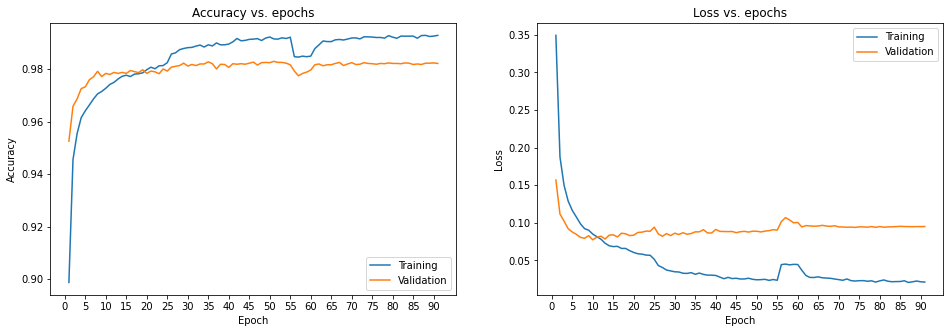

2021-08-10 08:35:27,458: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1
----------------------------------------evaluate----------------------------------------


2021-08-10 08:35:33,770: INFO: test loss:0.0878
2021-08-10 08:35:33,771: INFO: test accuracy:0.9830
2021-08-10 08:35:33,773: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 08:35:33,775: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 08:35:33,776: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator
2021-08-10 08:35:33,777: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator
2021-08-10 08:35:33,778: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 08:35:35,907: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator


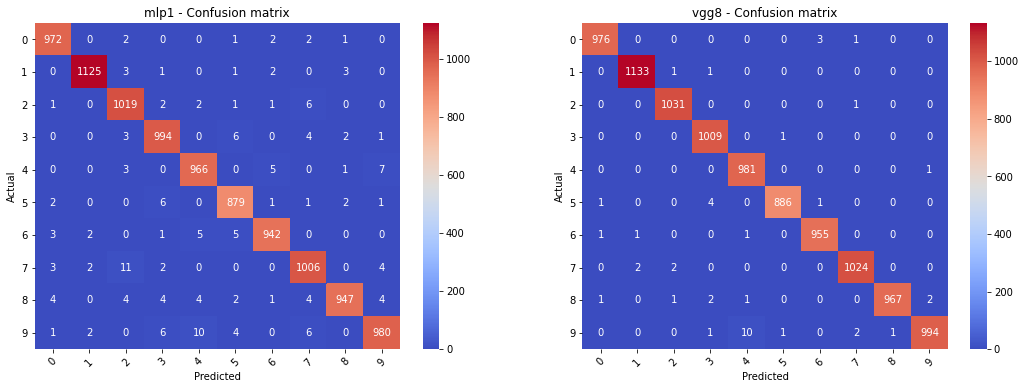

2021-08-10 08:35:40,346: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 08:35:42,212: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator
2021-08-10 08:35:42,214: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1
2021-08-10 08:35:43,093: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator
2021-08-10 08:35:43,095: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1
2021-08-10 08:35:44,200: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator
2021-08-10 08:35:44,202: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classific

2021-08-10 08:35:50,759: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f03fc0ed0d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


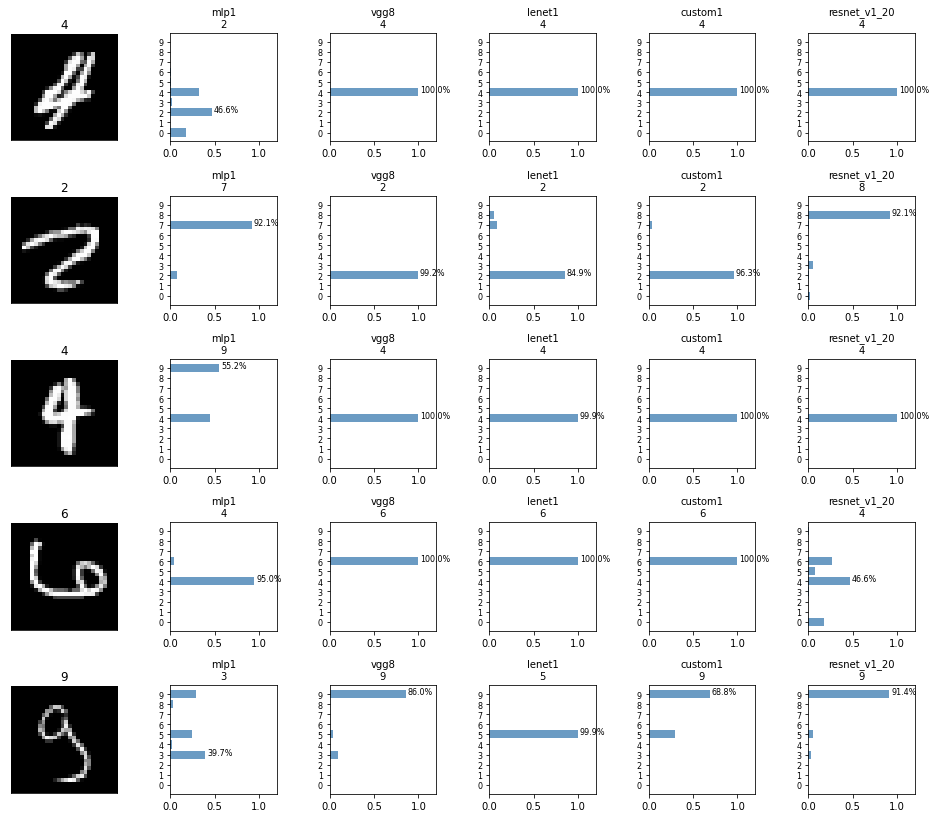

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,432.5,0.0089,0.0188,0.9972,0.9956,1.0000,1.0000
2,lenet1,61750,445.1,0.0052,0.0250,0.9983,0.9933,1.0000,1.0000
3,custom1,73162,191.6,0.0126,0.0232,0.9963,0.9930,1.0000,1.0000
4,resnet_v1_20,272778,940.5,0.0577,0.0676,0.9941,0.9912,1.0000,1.0000
5,mlp1,101770,383.0,0.0030,0.0878,0.9996,0.9830,1.0000,0.9996
6,mlp,101770,61.4,0.1729,0.2884,0.9575,0.9500,0.9981,0.9965


In [17]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2021-08-10 08:35:55,365: INFO: model_params.lenet1.dropout=0.2
2021-08-10 08:35:55,450: INFO: learning_rate=0.001
2021-08-10 08:35:55,451: INFO: model_params.lenet1.clip_value=None
2021-08-10 08:35:55,456: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1
2021-08-10 08:35:55,462: INFO: model_params.lenet1.epochs=120
2021-08-10 08:35:55,462: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1, monitor=val_accuracy)
2021-08-10 08:35:55,463: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:35:55,463: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:35:55,464: INFO: use LearningRateScheduler()
2021-08-10 08:35:55,465: INFO: steps_per_epoch=1875
2021-08-10 08:35:55,465: INFO: start training
2021-08-10 08:35:55,466: INFO: use_class_w

TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)
Model: "lenet1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_______________________________________________________________

2021-08-10 08:36:06,634: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 2/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1159 - accuracy: 0.9649 - val_loss: 0.0521 - val_accuracy: 0.9821
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 08:36:16,583: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 3/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0927 - accuracy: 0.9718 - val_loss: 0.0400 - val_accuracy: 0.9862
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 08:36:27,482: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 4/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0784 - accuracy: 0.9767 - val_loss: 0.0385 - val_accuracy: 0.9872
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 08:36:37,848: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 5/120
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0705 - accuracy: 0.9785 - val_loss: 0.0334 - val_accuracy: 0.9896
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 08:36:48,390: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 6/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0669 - accuracy: 0.9798 - val_loss: 0.0326 - val_accuracy: 0.9902
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 08:36:58,439: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 7/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0616 - accuracy: 0.9814 - val_loss: 0.0305 - val_accuracy: 0.9901
Epoch 8/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0571 - accuracy: 0.9831 - val_loss: 0.0267 - val_accuracy: 0.9917
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 08:37:16,854: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 9/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0549 - accuracy: 0.9836 - val_loss: 0.0259 - val_accuracy: 0.9919
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 08:37:26,799: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 10/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0498 - accuracy: 0.9851 - val_loss: 0.0263 - val_accuracy: 0.9908
Epoch 11/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0540 - accuracy: 0.9837 - val_loss: 0.0258 - val_accuracy: 0.9919
Epoch 12/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0482 - accuracy: 0.9854 - val_loss: 0.0252 - val_accuracy: 0.9924
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 08:37:52,640: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 13/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0467 - accuracy: 0.9859 - val_loss: 0.0275 - val_accuracy: 0.9911
Epoch 14/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0470 - accuracy: 0.9855 - val_loss: 0.0235 - val_accuracy: 0.9927
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 08:38:10,627: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 15/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0429 - accuracy: 0.9869 - val_loss: 0.0235 - val_accuracy: 0.9923
Epoch 16/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0430 - accuracy: 0.9866 - val_loss: 0.0264 - val_accuracy: 0.9918
Epoch 17/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0411 - accuracy: 0.9876 - val_loss: 0.0214 - val_accuracy: 0.9934
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 08:38:36,611: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 18/120
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0405 - accuracy: 0.9874 - val_loss: 0.0270 - val_accuracy: 0.9920
Epoch 19/120
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0398 - accuracy: 0.9874 - val_loss: 0.0237 - val_accuracy: 0.9923
Epoch 20/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0408 - accuracy: 0.9880 - val_loss: 0.0245 - val_accuracy: 0.9928
Epoch 21/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0384 - accuracy: 0.9879 - val_loss: 0.0279 - val_accuracy: 0.9916
Epoch 22/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0351 - accuracy: 0.9893 - val_loss: 0.0230 - val_accuracy: 0.9927
Epoch 23/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0355 - accuracy: 0.9889 - val_loss: 0.0226 - val_accuracy: 0.9937
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mn

2021-08-10 08:39:25,403: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 24/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0366 - accuracy: 0.9890 - val_loss: 0.0225 - val_accuracy: 0.9930
Epoch 25/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0334 - accuracy: 0.9898 - val_loss: 0.0249 - val_accuracy: 0.9924
Epoch 26/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0321 - accuracy: 0.9895 - val_loss: 0.0260 - val_accuracy: 0.9918
Epoch 27/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0335 - accuracy: 0.9898 - val_loss: 0.0275 - val_accuracy: 0.9927
Epoch 28/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0332 - accuracy: 0.9894 - val_loss: 0.0239 - val_accuracy: 0.9923
Epoch 29/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0330 - accuracy: 0.9901 - val_loss: 0.0251 - val_accuracy: 0.9916
Epoch 30/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0315 - accuracy: 0.9898 - val_loss: 0.0234 -

2021-08-10 08:40:47,422: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 34/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0270 - accuracy: 0.9912 - val_loss: 0.0249 - val_accuracy: 0.9929
Epoch 35/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0290 - accuracy: 0.9908 - val_loss: 0.0219 - val_accuracy: 0.9937
Epoch 36/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0297 - accuracy: 0.9913 - val_loss: 0.0261 - val_accuracy: 0.9918
Epoch 37/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0284 - accuracy: 0.9911 - val_loss: 0.0212 - val_accuracy: 0.9935
Epoch 38/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0286 - accuracy: 0.9909 - val_loss: 0.0231 - val_accuracy: 0.9929
Epoch 39/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0283 - accuracy: 0.9912 - val_loss: 0.0236 - val_accuracy: 0.9931
Epoch 40/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0273 - accuracy: 0.9913 - val_loss: 0.0222 -

2021-08-10 08:43:13,935: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 52/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0249 - accuracy: 0.9923 - val_loss: 0.0211 - val_accuracy: 0.9937
Epoch 53/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0260 - accuracy: 0.9920 - val_loss: 0.0200 - val_accuracy: 0.9943
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 08:43:32,345: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 54/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0252 - accuracy: 0.9923 - val_loss: 0.0223 - val_accuracy: 0.9935
Epoch 55/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0254 - accuracy: 0.9923 - val_loss: 0.0197 - val_accuracy: 0.9936
Epoch 56/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0250 - accuracy: 0.9919 - val_loss: 0.0246 - val_accuracy: 0.9920
Epoch 57/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0252 - accuracy: 0.9921 - val_loss: 0.0195 - val_accuracy: 0.9934
Epoch 58/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0248 - accuracy: 0.9920 - val_loss: 0.0191 - val_accuracy: 0.9946
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 08:44:14,527: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 59/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0232 - accuracy: 0.9927 - val_loss: 0.0220 - val_accuracy: 0.9940
Epoch 60/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0229 - accuracy: 0.9926 - val_loss: 0.0220 - val_accuracy: 0.9936
Epoch 61/120
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0199 - accuracy: 0.9936 - val_loss: 0.0208 - val_accuracy: 0.9946
Epoch 62/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0171 - accuracy: 0.9946 - val_loss: 0.0207 - val_accuracy: 0.9945
Epoch 63/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.0205 - val_accuracy: 0.9946
Epoch 64/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0168 - accuracy: 0.9945 - val_loss: 0.0196 - val_accuracy: 0.9949
INFO:tensorflow:Assets written to: /tf/eipi1

2021-08-10 08:45:07,164: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 65/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.0195 - val_accuracy: 0.9952
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 08:45:17,992: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 66/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0153 - accuracy: 0.9948 - val_loss: 0.0206 - val_accuracy: 0.9945
Epoch 67/120
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0151 - accuracy: 0.9951 - val_loss: 0.0196 - val_accuracy: 0.9948
Epoch 68/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0161 - accuracy: 0.9948 - val_loss: 0.0192 - val_accuracy: 0.9950
Epoch 69/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0152 - accuracy: 0.9951 - val_loss: 0.0191 - val_accuracy: 0.9949
Epoch 70/120
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0151 - accuracy: 0.9952 - val_loss: 0.0187 - val_accuracy: 0.9947
Epoch 71/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 0.0185 - val_accuracy: 0.9946
Epoch 72/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0154 - accuracy: 0.9952 - val_loss: 0.0186

2021-08-10 08:47:09,980: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 78/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0149 - accuracy: 0.9951 - val_loss: 0.0186 - val_accuracy: 0.9950
Epoch 79/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0135 - accuracy: 0.9959 - val_loss: 0.0184 - val_accuracy: 0.9948
Epoch 80/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0147 - accuracy: 0.9954 - val_loss: 0.0185 - val_accuracy: 0.9949
Epoch 81/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0130 - accuracy: 0.9959 - val_loss: 0.0185 - val_accuracy: 0.9951
Epoch 82/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0146 - accuracy: 0.9950 - val_loss: 0.0184 - val_accuracy: 0.9949
Epoch 83/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.0192 - val_accuracy: 0.9950
Epoch 84/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.0193 -

2021-08-10 08:53:00,556: INFO: finish training [elapsed time: 1025.09 seconds]


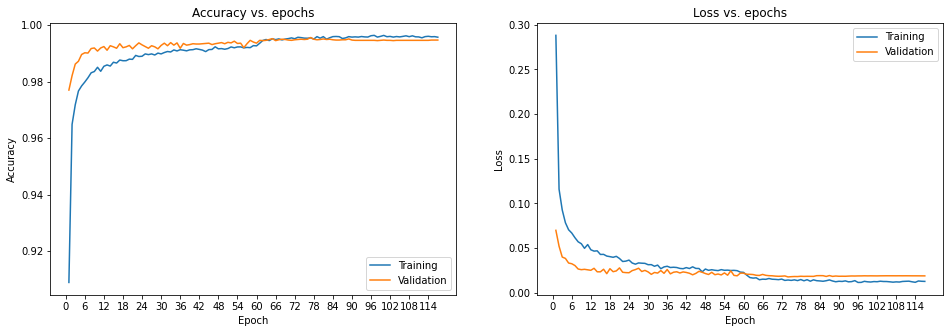

2021-08-10 08:53:01,167: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1
----------------------------------------evaluate----------------------------------------


2021-08-10 08:53:11,206: INFO: test loss:0.0182
2021-08-10 08:53:11,207: INFO: test accuracy:0.9956
2021-08-10 08:53:11,209: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 08:53:11,211: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 08:53:11,212: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator
2021-08-10 08:53:11,213: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator
2021-08-10 08:53:11,214: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 08:53:12,869: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator


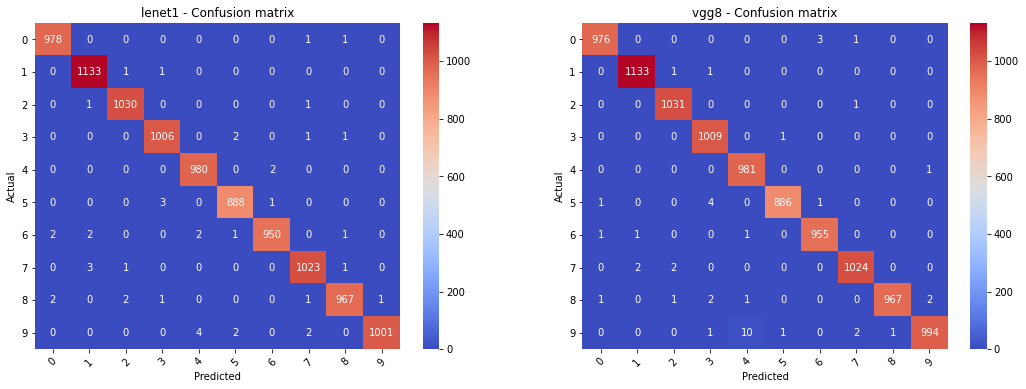

2021-08-10 08:53:16,569: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 08:53:18,701: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator
2021-08-10 08:53:18,705: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1
2021-08-10 08:53:19,759: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator
2021-08-10 08:53:19,761: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20
2021-08-10 08:53:25,042: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 08:53:25,044: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classif

2021-08-10 08:53:26,954: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f0490589b70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


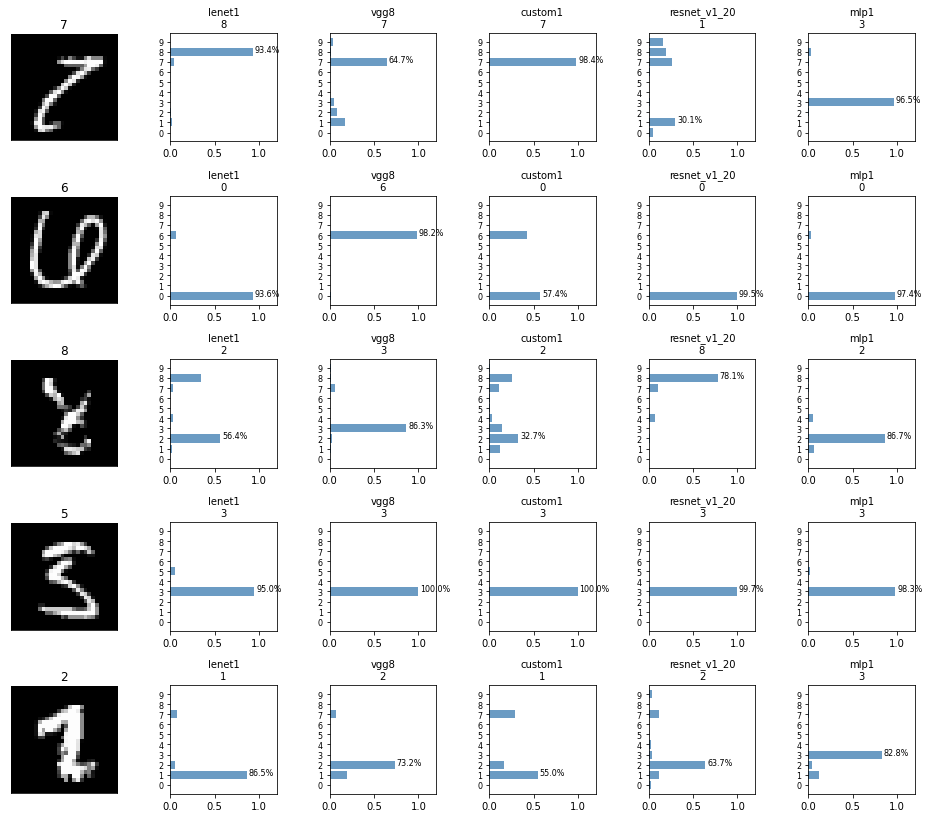

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,lenet1,61750,1024.6,0.0015,0.0182,0.9996,0.9956,1.0000,1.0000
2,vgg8,1442378,432.5,0.0089,0.0188,0.9972,0.9956,1.0000,1.0000
3,custom1,73162,191.6,0.0126,0.0232,0.9963,0.9930,1.0000,1.0000
4,resnet_v1_20,272778,940.5,0.0577,0.0676,0.9941,0.9912,1.0000,1.0000
5,mlp1,101770,383.0,0.0030,0.0878,0.9996,0.9830,1.0000,0.9996
6,mlp,101770,61.4,0.1729,0.2884,0.9575,0.9500,0.9981,0.9965


In [18]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2021-08-10 08:53:31,521: INFO: model_params.custom1.dropout=0.3
2021-08-10 08:53:31,632: INFO: learning_rate=0.001
2021-08-10 08:53:31,633: INFO: model_params.custom1.clip_value=None
2021-08-10 08:53:31,640: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1
2021-08-10 08:53:31,648: INFO: model_params.custom1.epochs=120
2021-08-10 08:53:31,649: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1, monitor=val_accuracy)
2021-08-10 08:53:31,650: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:53:31,650: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:53:31,651: INFO: use LearningRateScheduler()
2021-08-10 08:53:31,652: INFO: steps_per_epoch=1875
2021-08-10 08:53:31,652: INFO: start training
2021-08-10 08:53:31,653: INFO: use_cl

TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)
Model: "custom1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
______________________________________________________________

2021-08-10 08:53:45,722: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 2/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1146 - accuracy: 0.9661 - val_loss: 0.0378 - val_accuracy: 0.9873
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


2021-08-10 08:53:59,706: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 3/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0878 - accuracy: 0.9749 - val_loss: 0.0315 - val_accuracy: 0.9903
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


2021-08-10 08:54:12,961: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 4/120
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0765 - accuracy: 0.9771 - val_loss: 0.0311 - val_accuracy: 0.9911
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


2021-08-10 08:54:25,385: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 5/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0669 - accuracy: 0.9805 - val_loss: 0.0317 - val_accuracy: 0.9903
Epoch 6/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0642 - accuracy: 0.9806 - val_loss: 0.0260 - val_accuracy: 0.9918
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


2021-08-10 08:54:48,985: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 7/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0563 - accuracy: 0.9830 - val_loss: 0.0250 - val_accuracy: 0.9927
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


2021-08-10 08:55:01,886: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 8/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0571 - accuracy: 0.9828 - val_loss: 0.0223 - val_accuracy: 0.9935
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


2021-08-10 08:55:15,241: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 9/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0522 - accuracy: 0.9841 - val_loss: 0.0246 - val_accuracy: 0.9920
Epoch 10/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0517 - accuracy: 0.9851 - val_loss: 0.0236 - val_accuracy: 0.9933
Epoch 11/120
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0465 - accuracy: 0.9866 - val_loss: 0.0246 - val_accuracy: 0.9929
Epoch 12/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0454 - accuracy: 0.9866 - val_loss: 0.0302 - val_accuracy: 0.9919
Epoch 13/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0436 - accuracy: 0.9868 - val_loss: 0.0231 - val_accuracy: 0.9930
Epoch 14/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0417 - accuracy: 0.9877 - val_loss: 0.0217 - val_accuracy: 0.9936
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/outp

2021-08-10 08:56:21,882: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 15/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0407 - accuracy: 0.9876 - val_loss: 0.0226 - val_accuracy: 0.9930
Epoch 16/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0405 - accuracy: 0.9879 - val_loss: 0.0263 - val_accuracy: 0.9927
Epoch 17/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0367 - accuracy: 0.9885 - val_loss: 0.0282 - val_accuracy: 0.9924
Epoch 18/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0376 - accuracy: 0.9888 - val_loss: 0.0250 - val_accuracy: 0.9932
Epoch 19/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0371 - accuracy: 0.9885 - val_loss: 0.0251 - val_accuracy: 0.9925
Epoch 20/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0365 - accuracy: 0.9888 - val_loss: 0.0278 - val_accuracy: 0.9915
Epoch 21/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0337 - accuracy: 0.9896 - val_loss: 0

2021-08-10 08:57:49,143: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 23/120
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0330 - accuracy: 0.9894 - val_loss: 0.0277 - val_accuracy: 0.9924
Epoch 24/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0336 - accuracy: 0.9901 - val_loss: 0.0225 - val_accuracy: 0.9936
Epoch 25/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0320 - accuracy: 0.9904 - val_loss: 0.0244 - val_accuracy: 0.9938
Epoch 26/120
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0334 - accuracy: 0.9902 - val_loss: 0.0226 - val_accuracy: 0.9938
Epoch 27/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0321 - accuracy: 0.9907 - val_loss: 0.0236 - val_accuracy: 0.9934
Epoch 28/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0311 - accuracy: 0.9905 - val_loss: 0.0234 - val_accuracy: 0.9935
Epoch 29/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0292 - accuracy: 0.9910 - val_loss: 0

2021-08-10 08:59:16,149: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 31/120
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0232 - accuracy: 0.9926 - val_loss: 0.0229 - val_accuracy: 0.9938
Epoch 32/120
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0217 - accuracy: 0.9931 - val_loss: 0.0219 - val_accuracy: 0.9946
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


2021-08-10 08:59:40,165: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 33/120
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0217 - val_accuracy: 0.9943
Epoch 34/120
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0210 - accuracy: 0.9932 - val_loss: 0.0228 - val_accuracy: 0.9940
Epoch 35/120
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0202 - accuracy: 0.9936 - val_loss: 0.0231 - val_accuracy: 0.9939
Epoch 36/120
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0199 - accuracy: 0.9939 - val_loss: 0.0224 - val_accuracy: 0.9944
Epoch 37/120
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0199 -

2021-08-10 09:00:47,956: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 39/120
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0191 - accuracy: 0.9941 - val_loss: 0.0216 - val_accuracy: 0.9948
Epoch 40/120
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0185 - accuracy: 0.9943 - val_loss: 0.0214 - val_accuracy: 0.9947
Epoch 41/120
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0195 - accuracy: 0.9941 - val_loss: 0.0213 - val_accuracy: 0.9944
Epoch 42/120
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0184 - accuracy: 0.9942 - val_loss: 0.0204 - val_accuracy: 0.9947
Epoch 43/120
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0183 -

2021-08-10 09:08:01,635: INFO: finish training [elapsed time: 869.98 seconds]


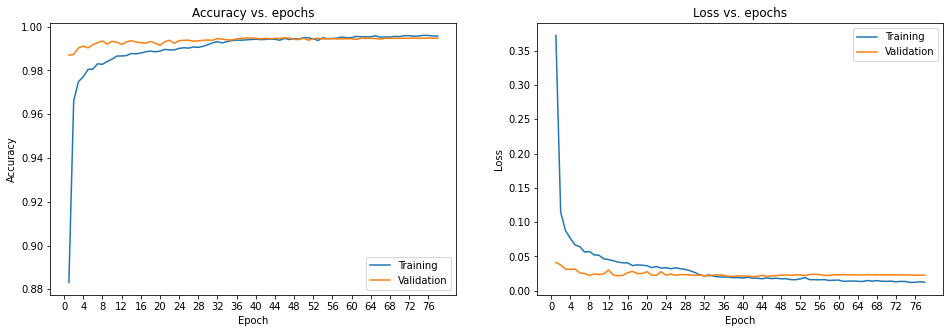

2021-08-10 09:08:02,176: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1
----------------------------------------evaluate----------------------------------------


2021-08-10 09:08:13,875: INFO: test loss:0.0211
2021-08-10 09:08:13,875: INFO: test accuracy:0.9949
2021-08-10 09:08:13,877: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 09:08:13,879: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 09:08:13,879: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator
2021-08-10 09:08:13,880: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator
2021-08-10 09:08:13,881: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 09:08:14,927: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator


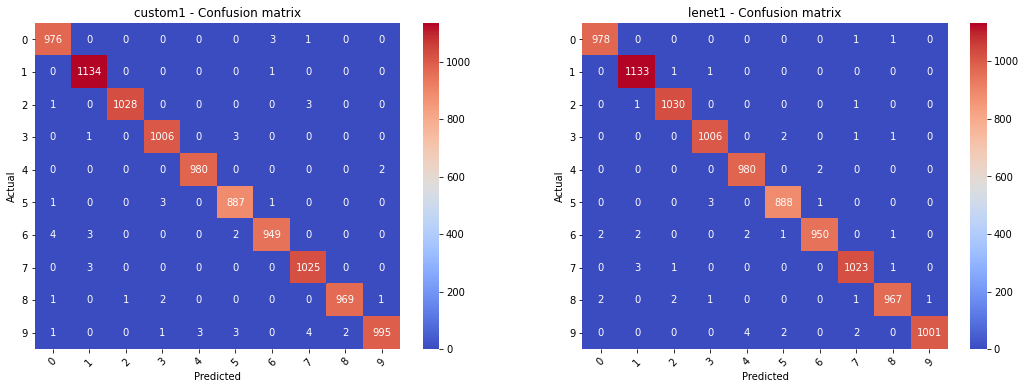

2021-08-10 09:08:18,426: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1


----------------------------------------sample analysis----------------------------------------


2021-08-10 09:08:19,309: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator
2021-08-10 09:08:19,311: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8
2021-08-10 09:08:21,491: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/default.generator
2021-08-10 09:08:21,494: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20
2021-08-10 09:08:26,598: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 09:08:26,600: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classifica

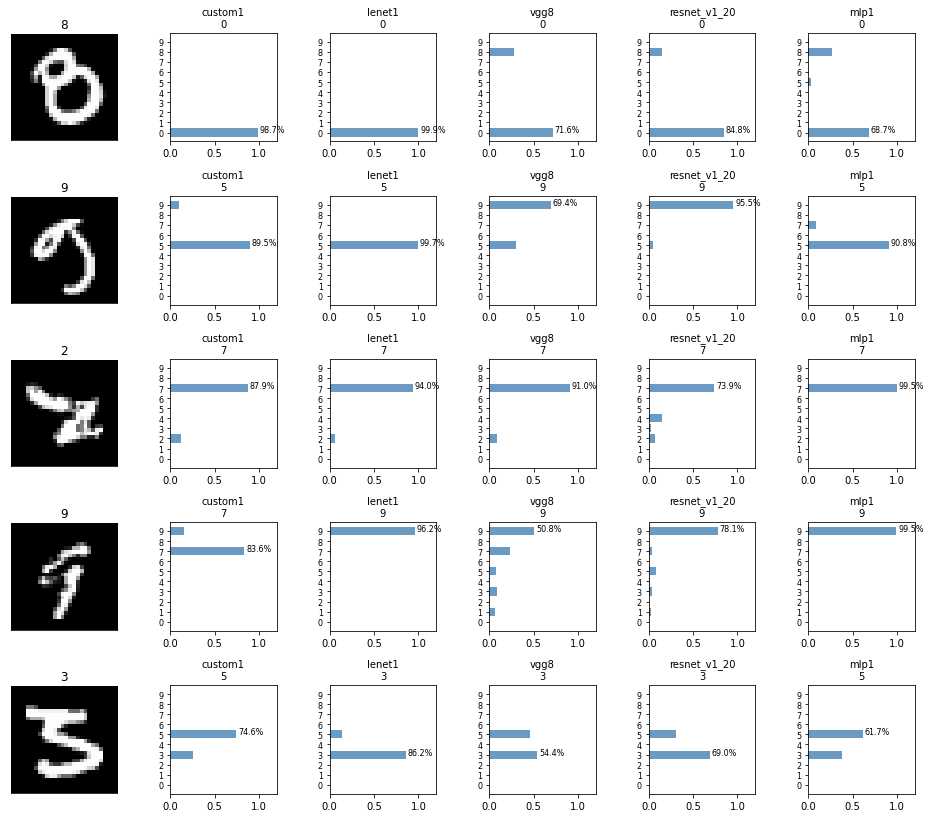

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,lenet1,61750,1024.6,0.0015,0.0182,0.9996,0.9956,1.0000,1.0000
2,vgg8,1442378,432.5,0.0089,0.0188,0.9972,0.9956,1.0000,1.0000
3,custom1,73162,869.5,0.0026,0.0211,0.9992,0.9949,1.0000,1.0000
4,resnet_v1_20,272778,940.5,0.0577,0.0676,0.9941,0.9912,1.0000,1.0000
5,mlp1,101770,383.0,0.0030,0.0878,0.9996,0.9830,1.0000,0.9996
6,mlp,101770,61.4,0.1729,0.2884,0.9575,0.9500,0.9981,0.9965


In [19]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

2021-08-10 09:08:32,972: INFO: model_params.vgg8.dropout=0.4


TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)


2021-08-10 09:08:33,137: INFO: learning_rate=0.001
2021-08-10 09:08:33,138: INFO: model_params.vgg8.clip_value=None
2021-08-10 09:08:33,144: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8
2021-08-10 09:08:33,152: INFO: model_params.vgg8.epochs=120
2021-08-10 09:08:33,152: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8, monitor=val_accuracy)
2021-08-10 09:08:33,153: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 09:08:33,154: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 09:08:33,155: INFO: use LearningRateScheduler()
2021-08-10 09:08:33,156: INFO: steps_per_epoch=1875
2021-08-10 09:08:33,156: INFO: start training
2021-08-10 09:08:33,157: INFO: use_class_weight=False


Model: "vgg8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_con1 (Conv2D)         (None, 28, 28, 64)        640       
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 28, 28, 64)        256       
_________________________________________________________________
block1_relu1 (ReLU)          (None, 28, 28, 64)        0         
_________________________________________________________________
block1_con2 (Conv2D)         (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 28, 28, 64)        256       
_________________________________________________________________
block1_relu2 (ReLU)          (None, 28, 28, 64)        0      

2021-08-10 09:09:03,496: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 2/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1059 - accuracy: 0.9708 - val_loss: 0.0387 - val_accuracy: 0.9874
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


2021-08-10 09:09:31,398: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 3/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0827 - accuracy: 0.9775 - val_loss: 0.0393 - val_accuracy: 0.9891
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


2021-08-10 09:10:00,242: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 4/120
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0641 - accuracy: 0.9827 - val_loss: 0.0246 - val_accuracy: 0.9924
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


2021-08-10 09:10:28,894: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 5/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0546 - accuracy: 0.9847 - val_loss: 0.0258 - val_accuracy: 0.9928
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


2021-08-10 09:10:57,460: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 6/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0466 - accuracy: 0.9876 - val_loss: 0.0236 - val_accuracy: 0.9923
Epoch 7/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0398 - accuracy: 0.9894 - val_loss: 0.0269 - val_accuracy: 0.9933
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


2021-08-10 09:11:49,876: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 8/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0364 - accuracy: 0.9901 - val_loss: 0.0202 - val_accuracy: 0.9943
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


2021-08-10 09:12:18,457: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 9/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0327 - accuracy: 0.9908 - val_loss: 0.0164 - val_accuracy: 0.9953
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


2021-08-10 09:12:46,858: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 10/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0281 - accuracy: 0.9920 - val_loss: 0.0175 - val_accuracy: 0.9947
Epoch 11/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0258 - accuracy: 0.9922 - val_loss: 0.0208 - val_accuracy: 0.9938
Epoch 12/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0237 - accuracy: 0.9933 - val_loss: 0.0205 - val_accuracy: 0.9941
Epoch 13/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0239 - accuracy: 0.9932 - val_loss: 0.0203 - val_accuracy: 0.9942
Epoch 14/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0220 - accuracy: 0.9938 - val_loss: 0.0168 - val_accuracy: 0.9960
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


2021-08-10 09:14:48,145: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 15/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0195 - accuracy: 0.9941 - val_loss: 0.0151 - val_accuracy: 0.9959
Epoch 16/120
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0198 - accuracy: 0.9944 - val_loss: 0.0195 - val_accuracy: 0.9954
Epoch 17/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0195 - accuracy: 0.9944 - val_loss: 0.0174 - val_accuracy: 0.9948
Epoch 18/120
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0182 - accuracy: 0.9949 - val_loss: 0.0223 - val_accuracy: 0.9940
Epoch 19/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0183 - accuracy: 0.9949 - val_loss: 0.0218 - val_accuracy: 0.9955
Epoch 20/120
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0156 - accuracy: 0.9952 - val_loss: 0.0277 - val_accuracy: 0.9935
Epoch 21/120
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0141 - accuracy: 0.9959 - val_

2021-08-10 09:21:47,402: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 32/120
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0049 - accuracy: 0.9983 - val_loss: 0.0215 - val_accuracy: 0.9961
Epoch 33/120
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0048 - accuracy: 0.9985 - val_loss: 0.0192 - val_accuracy: 0.9961
Epoch 34/120
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.0201 - val_accuracy: 0.9961
Epoch 35/120
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0048 - accuracy: 0.9984 - val_loss: 0.0212 - val_accuracy: 0.9959
Epoch 36/120
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0

2021-08-10 09:24:18,676: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 38/120
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.0232 - val_accuracy: 0.9958
Epoch 39/120
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0238 - val_accuracy: 0.9955
Epoch 40/120
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0246 - val_accuracy: 0.9960
Epoch 41/120
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
 520/1875 [=======>......................] - ETA: 17s - loss: 0.0028 - accuracy: 0.9990

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [ ]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

In [ ]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [ ]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

In [ ]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

In [ ]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [ ]:
type(helper.datasets.train_dataset)